In [14]:
import pickle
import matplotlib.pyplot as plt

In [15]:
import torch
import torchvision

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

In [17]:
from PIL import Image
import numpy as np
import PIL.ImageOps

In [18]:
from werkzeug.wrappers import Request, Response
from flask import Flask
from flask import render_template
from flask import request
from werkzeug.serving import run_simple

In [19]:
from io import BytesIO
import base64

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [21]:
network = pickle.load(open("network.p", "rb"))

In [22]:
def predict(im):
    im = im.resize((28,28))
    im = im.convert('L')
        
    pixels = im.load()
    
    for i in range(im.size[0]): # for every pixel:
        for j in range(im.size[1]):
            if pixels[i,j] < 100:
                pixels[i,j] = 255
            else:
                pixels[i,j] = 0
            #pixels[i,j] = 255-pixels[i,j]

    plt.imshow(im)
            
    trans1 = transforms.ToTensor()
    trans2 = transforms.Normalize((0.1307,), (0.3081,))
    im = trans2(trans1(im))
    
    hello = im.numpy()
    hello = np.expand_dims(hello, axis=0)
    im = torch.from_numpy(hello)
    
    output = network(im)
        
    print(output)
        
    return output.data.max(1, keepdim=True)[1][0].item()

tensor([[ -4.3670, -11.4438,  -9.7494, -10.9486, -10.9044,  -1.4255,  -0.5118,
         -14.8601,  -1.9158,  -8.7960]], grad_fn=<LogSoftmaxBackward>)
6


/home/rabbi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


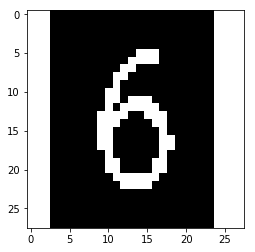

In [23]:
im = Image.open("6.jpg")
print(predict(im))

In [24]:
app = Flask(__name__)

In [25]:
@app.route('/predict_digit', methods=['POST'])
def predict_digit():
    encoded = request.form['encoded']
    
    im = Image.open(BytesIO(base64.b64decode(encoded)))
            
    return str(predict(im))

In [ ]:
if __name__ == '__main__':
    run_simple('0.0.0.0', 9000, app)

 * Running on http://0.0.0.0:9000/ (Press CTRL+C to quit)
/home/rabbi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
192.168.0.106 - - [14/Nov/2018 01:06:51] "POST /predict_digit HTTP/1.1" 200 -


tensor([[ -3.8563, -18.8443, -14.3077, -14.4287, -20.7476,  -0.0580,  -3.4753,
         -16.9230,  -5.4697, -12.3260]], grad_fn=<LogSoftmaxBackward>)


192.168.0.106 - - [14/Nov/2018 01:07:13] "POST /predict_digit HTTP/1.1" 200 -


tensor([[ -3.8739, -15.8167, -12.8065, -13.3994, -13.4677,  -2.8433,  -0.0833,
         -15.1383,  -7.0040, -10.1579]], grad_fn=<LogSoftmaxBackward>)


192.168.0.106 - - [14/Nov/2018 01:08:16] "POST /predict_digit HTTP/1.1" 200 -


tensor([[-14.2894, -10.1499, -10.0869,  -1.5889,  -3.4619,  -3.3720, -13.2224,
         -13.4951,  -2.3336,  -0.4571]], grad_fn=<LogSoftmaxBackward>)


192.168.0.106 - - [14/Nov/2018 01:09:45] "POST /predict_digit HTTP/1.1" 200 -


tensor([[-26.0324, -22.2529, -18.4604, -21.4242,  -0.0002, -19.9242, -17.4135,
         -20.2821, -15.3882,  -8.4462]], grad_fn=<LogSoftmaxBackward>)


192.168.0.106 - - [14/Nov/2018 01:10:22] "POST /predict_digit HTTP/1.1" 200 -


tensor([[-18.2941, -20.3638, -21.3381, -12.0697, -20.0332,  -0.0000, -13.7999,
         -20.7096, -14.2839, -11.9303]], grad_fn=<LogSoftmaxBackward>)
